# **Course**: Deep Learning

[<img align="right" width="400" height="100" src="https://www.tu-braunschweig.de/typo3conf/ext/tu_braunschweig/Resources/Public/Images/Logos/tu_braunschweig_logo.svg">](https://www.tu-braunschweig.de/en/)

[Mehdi Maboudi](https://www.tu-braunschweig.de/en/igp/staff/mehdi-maboudi) \([m.maboudi@tu-bs.de](m.maboudi@tu-bs.de)) and [Pedro Achanccaray](https://www.tu-braunschweig.de/en/igp/staff/pedro-diaz) (p.diaz@tu-bs.de)

[Technical University of Braunschweig](https://www.tu-braunschweig.de/en/)  
[Institute of Geodesy and Photogrammetry](https://www.tu-braunschweig.de/igp)

# **Assignment 02:** EDA for remote sensing dataset

## **Recommendations**

### **1. Do not upload datasets or heavy files to your repository!**

The purpose of a repository is **to track all changes made** to files in your project.

Thus, you **must include** only files that will **change**. For instance:
- Code (functions, classes, etc.)
- Configuration files
- ...

You **must avoid**:
- Datasets (images, videos, etc.)
- Temporal files
- Cache files
- ...

For that reason, you must use the **`.gitignore`** file, to filter folders and files that are not needed in the repository.

**Example:**

```python
# These are some examples. You may update it based on your requirements.
# DO NOT FORGET to add datasets folders here!

#Notebooks' checkpoints
.ipynb_checkpoints

#bytecodes
__pycache__

#videos
*.m4v

#MacOS
__MACOSX
.DS_Store

# Spyder project settings
.spyderproject
.spyproject

# Environments
.env

# Visual Studio Code
.vscode
```

You can find `gitignore` templates in this repository: [gitignore](https://github.com/github/gitignore). This is a template for Python: [Python gitignore](https://github.com/github/gitignore/blob/main/Python.gitignore)

### **2. EDA depends on your application (task)**

Depending on your **application or task**, it might be more interesting to see different **statistics** or **figures** from your dataset.

For instance:
- **Classification:** number of images per class, images visualization, images sizes, class variability, context of each class, incorrect or missing labels, appeareance (brigthness and contrast)...
- **Semantic segmentation:** number of pixels per class, images visualization (True RGB or False RGB compositions), segmentation mask, incorrect labels, class variability (pixel values),...
- **Object detection:** number of objects per class, images and objects aspect ratios per class,...

# **Lab 02:** **M**ulti **L**ayer **P**erceptron (MLP) for Image Classification

In this lab session, we will use the [UC Merced](http://weegee.vision.ucmerced.edu/datasets/landuse.html) dataset to cover the following topics:
- MLP for image classification
- Data generators
- Tensorboard and Tensorboard Dev

This dataset has the following classes:

<center>

|Class| Description ||| Class | Description |
|:---:|:-----------:|||:-----:|:-----------:|
|  0  | agricultural|||  10   |    harbor   |
|  1  |  airplane   |||  11   |intersection |
|  2  |baseballdiamond|||12   |mediumresidential|
|  3  |   beach     |||  13   |mobilehomepark|
|  4  |  buildings  |||  14   |  overpass   |
|  5  |  chaparral  |||  15   | parkinglot  |
|  6  |denseresidential|||16  |    river    |
|  7  |    forest   |||  17   |   runway    |
|  8  |  freeway    |||  18   |sparseresidential|
|  9  | golfcourse  |||  19   | storagetanks|
|     |             |||  20   | tenniscourt |

</center>

Some samples of each class are:
<center>
<img width=600 src="https://storage.googleapis.com/tfds-data/visualization/fig/uc_merced-2.0.0.png" img>
</center>

## **Mount Google Drive to Google Colab**

You can **skip** the following cells if you **do not want to storage** the trained model in your Google Drive.

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Change **this path** to the **path of a folder** in your Google Drive to storage the files associated to this session (trained model, figures for visualization, etc.)

In [2]:
# # %cd drive/MyDrive/PATH/TO/YOUR/FOLDER
# %cd drive/MyDrive/Colabs/DeepLearning_course/Lab_02

## **Load packages and data**

In [3]:
# Management of files
import os
from os.path import exists, join
from glob import glob
from natsort import natsorted

# Tensorflow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, \
                                    Flatten, \
                                    Dropout, \
                                    BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, \
                                       EarlyStopping, \
                                       TensorBoard
from tensorflow.keras.utils import to_categorical

# Visualization
import matplotlib.pyplot as plt

# Working with arrays
import numpy as np

# Split dataset and shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Working with images
import tifffile
import cv2

# Pandas
import pandas as pd

**Variables**

In [4]:
# PROJECT_DIR = "." # os.getcwd()
# Get the current directory of the script
current_dir = os.path.dirname(__file__) if "__file__" in locals() else "."
 

### **Download the dataset**

First, we will download the data for this session from the given link.

For this, we will use **`wget`** and **`zipfile`** packages to download the zip file **`data_satellite.zip`** and to extract its content.

_In case of error during the download, you can download the dataset directly from [here](http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip)._

In [5]:
url_dataset = "http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip"
filename = "UCMerced_LandUse.zip"

if not exists("UCMerced_LandUse"):
  !pip install wget
  import wget
  f = wget.download(url_dataset, current_dir)
  import zipfile
  with zipfile.ZipFile(filename, "r") as zip_ref:
    zip_ref.extractall(".")
  os.remove(join(current_dir, filename))

Let's see the structure of the folder using the **`tree`** command:

In [6]:
!apt-get install tree
!tree UCMerced_LandUse --du -h -L 2

'apt-get' is not recognized as an internal or external command,
operable program or batch file.


Too many parameters - --du


Usually, each dataset has a README file with information about how the dataset was built.

In [7]:
!fmt UCMerced_LandUse/readme.txt

'fmt' is not recognized as an internal or external command,
operable program or batch file.


Now, we know that there are 21 classes.

There is a folder for each class, and each folder should have 100 images in TIF format.

In [8]:
!echo "Content of one folder"
!find UCMerced_LandUse/Images/agricultural/ -name *.tif | sort -n | head -n 3

!echo -e "\nNumber of files per folder"
!find UCMerced_LandUse/Images -type d | sort | while read -r dir; do n=$(find "$dir" -type f | wc -l); printf "%4d : %s\n" $n "$dir"; done

"Content of one folder"


File not found - *.tif
'head' is not recognized as an internal or external command,
operable program or batch file.


-e "\nNumber of files per folder"


FIND: Parameter format not correct
'while' is not recognized as an internal or external command,
operable program or batch file.


**Important:**

You always have to **verify** **the information provided with the dataset** (e.g., README file, description) with **the files you downloaded**.

If these informations are different (e.g., number of images, number of classes), you should look for possible reasons (e.g., errors during downloading/uncompressing the files, not enough space, etc.)

### **Reading the dataset**

For a better management of the dataset, let's create a **dataframe**.

Then, for each image path, we will extract the **class label** of each image.

In [9]:
path_data = join(current_dir, "UCMerced_LandUse", "Images")

# List with all TIF images in the folder
list_img = glob(join(path_data, "**", "*.tif"), recursive=True)
list_img = natsorted(list_img, key=lambda y: y.lower())

# Dataframe for better management of image paths
df = pd.DataFrame(list_img, columns=["path_image"])

# Getting class name from filename path
# Example: ./UCMerced_LandUse/Images/agricultural/agricultural00.tif
#          class = agricultural
df["class_str"] = df["path_image"].apply(lambda x: x.split("\\")[-2])


df

,path_image,class_str
0,.\UCMerced_LandUse\Images\agricultural\agricul...,agricultural
1,.\UCMerced_LandUse\Images\agricultural\agricul...,agricultural
2,.\UCMerced_LandUse\Images\agricultural\agricul...,agricultural
3,.\UCMerced_LandUse\Images\agricultural\agricul...,agricultural
4,.\UCMerced_LandUse\Images\agricultural\agricul...,agricultural
...,...,...
2095,.\UCMerced_LandUse\Images\tenniscourt\tennisco...,tenniscourt
2096,.\UCMerced_LandUse\Images\tenniscourt\tennisco...,tenniscourt
2097,.\UCMerced_LandUse\Images\tenniscourt\tennisco...,tenniscourt
2098,.\UCMerced_LandUse\Images\tenniscourt\tennisco...,tenniscourt


To train a model, we need each **class label** as a **number**.

So, we can create a **dictionary** to convert each label from **`string`** to **`integer`**.

In [10]:
classes = np.unique(df["class_str"].values)
n_classes = len(classes)
print("Available classes: {}".format(classes))

classes_int = np.arange(len(classes))
classes_dict = dict(zip(classes, classes_int))
print("\nDictionary for classes:")
for key,value in classes_dict.items():
  print("{} : {}".format(key, value))

# Applying the dictionary to the column "class"
df["class_int"] = df["class_str"].apply(lambda x: classes_dict[x])

# Shuffle the dataframe rows without keeping the old index
df = df.sample(frac=1).reset_index(drop=True)

df

Available classes: ['agricultural' 'airplane' 'baseballdiamond' 'beach' 'buildings'
 'chaparral' 'denseresidential' 'forest' 'freeway' 'golfcourse' 'harbor'
 'intersection' 'mediumresidential' 'mobilehomepark' 'overpass'
 'parkinglot' 'river' 'runway' 'sparseresidential' 'storagetanks'
 'tenniscourt']

Dictionary for classes:
agricultural : 0
airplane : 1
baseballdiamond : 2
beach : 3
buildings : 4
chaparral : 5
denseresidential : 6
forest : 7
freeway : 8
golfcourse : 9
harbor : 10
intersection : 11
mediumresidential : 12
mobilehomepark : 13
overpass : 14
parkinglot : 15
river : 16
runway : 17
sparseresidential : 18
storagetanks : 19
tenniscourt : 20


,path_image,class_str,class_int
0,.\UCMerced_LandUse\Images\sparseresidential\sp...,sparseresidential,18
1,.\UCMerced_LandUse\Images\mobilehomepark\mobil...,mobilehomepark,13
2,.\UCMerced_LandUse\Images\denseresidential\den...,denseresidential,6
3,.\UCMerced_LandUse\Images\airplane\airplane49.tif,airplane,1
4,.\UCMerced_LandUse\Images\parkinglot\parkinglo...,parkinglot,15
...,...,...,...
2095,.\UCMerced_LandUse\Images\parkinglot\parkinglo...,parkinglot,15
2096,.\UCMerced_LandUse\Images\buildings\buildings8...,buildings,4
2097,.\UCMerced_LandUse\Images\runway\runway90.tif,runway,17
2098,.\UCMerced_LandUse\Images\river\river13.tif,river,16


### **Train, Validation and Test sets**

Now, we can create **three disjoint** sets: `train`, `validation` and `test`.

Let's use the following proportions:
- `train`: 60%
- `validation`: 20%
- `test`: 20%

**Remember:** it is very important that at least `train` and `validation` sets have samples of **all available classes**.

For this, we can use **stratified sampling**.

The [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function from scikit-learn has a parameter to split the data in a stratified fashion.

In [11]:
# Train and test split
# 80% for training, 20% for testing
x_train, x_test, y_train, y_test = train_test_split(df["path_image"].values,
                                                    df["class_int"].values,
                                                    test_size=0.2,
                                                    stratify=df["class_int"].values)

# Train and validation split
# 80% for training: 75% for training, 25% for validation
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.25,
                                                  stratify=y_train)

### **Visualization**

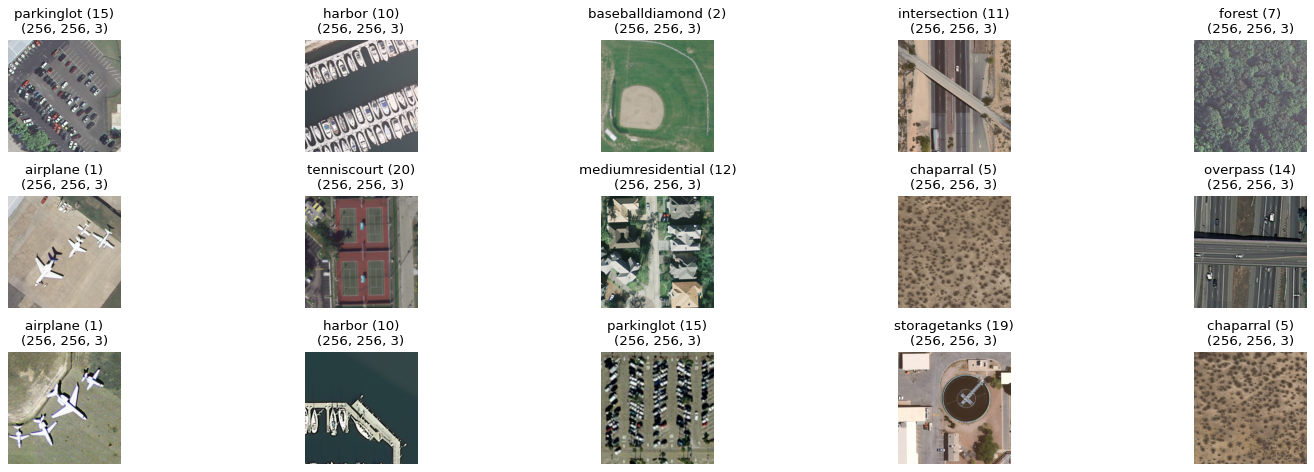

In [12]:
#@title ####**Image samples visualization** { run: "auto"}
#@markdown Select a sample
i = 70 #@param {type:"slider", min:0, max:139, step:1}
n = 15

plt.figure(figsize=(20,6), dpi=80)

for idx_df, row in df[i*n:i*n+n].iterrows():
  # reading the image
  image = tifffile.imread(row["path_image"])
  # getting the corresponding label
  label = row["class_str"]
  label_int = row["class_int"]

  plt.subplot(3,5,idx_df-i*n+1)
  plt.imshow(image)
  plt.title('{} ({})\n{}'.format(label,
                                 label_int,
                                 image.shape))
  plt.axis("off")
plt.tight_layout()

#### **Class distribution**

For **sanity check**, let's verify the **class distribution** of each set: `train`, `validation` and `test`.

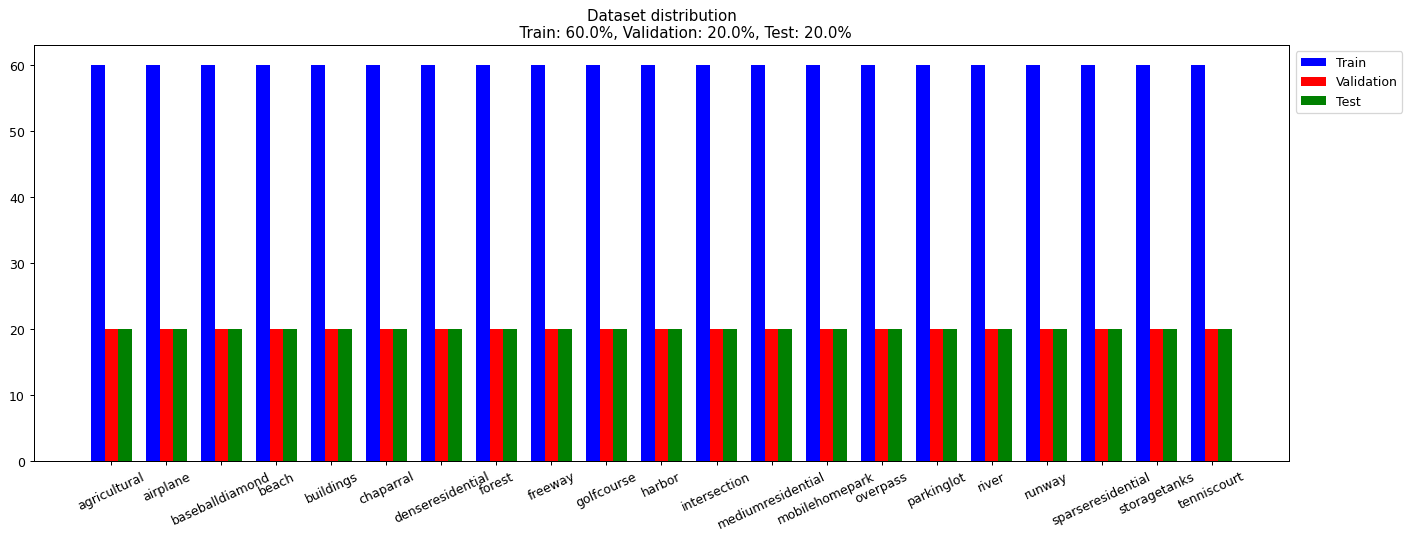

Samples per class - train: [60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60 60]
Samples per class - val: [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]
Samples per class - test: [20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20 20]


In [13]:
# Number of samples per class
_, counts_train = np.unique(y_train, return_counts=True)
_, counts_val = np.unique(y_val, return_counts=True)
_, counts_test = np.unique(y_test, return_counts=True)

# Figure configuration
bar_width = 0.25
br1 = np.arange(n_classes)
br2 = [x + bar_width for x in br1]
br3 = [x + bar_width for x in br2]

# Percentage of samples in each set
total_samples = sum(counts_train) + sum(counts_val) + sum(counts_test)
p_train = 100*sum(counts_train)/total_samples
p_val = 100*sum(counts_val)/total_samples
p_test = 100*sum(counts_test)/total_samples

# Bar plot
plt.figure(figsize=(18,6), dpi=90)

plt.bar(br1, counts_train, width=bar_width, color="blue", label="Train")
plt.bar(br2, counts_val, width=bar_width, color="red", label="Validation")
plt.bar(br3, counts_test, width=bar_width, color="green", label="Test")

plt.xticks([r + bar_width for r in range(n_classes)], classes, rotation=25)
plt.legend(loc="upper left", bbox_to_anchor=(1,1))
plt.title("Dataset distribution\n\
          Train: {}%, Validation: {}%, Test: {}%".format(p_train,
                                                         p_val,
                                                         p_test))
plt.show()

print("Samples per class - train: {}".format(counts_train))
print("Samples per class - val: {}".format(counts_val))
print("Samples per class - test: {}".format(counts_test))

## **Data generator**

**Current scenario:**

<center>
<img src="https://drive.google.com/uc?export=view&id=1QptKJilSAqgBlL5mpP99OxXqbkyw5l-K" height=400/>
</center>

**Is there any potential problem here?**

**Using data generators**

<center>
<img src="https://drive.google.com/uc?export=view&id=1JNha7_uCJDscbII2kp2YNcS4roFLZ6dL" height=400/>
</center>

A data generator allows us to deal with **large datasets**, when it is not possible to **load** the whole dataset in memory.

There are many options to use data generators. We will see two options to use data generators in **Keras** (for **Pytorch**, visit the following [link](https://stanford.edu/~shervine/blog/pytorch-how-to-generate-data-parallel)):

- ImageDataGenerator class
- Custom data generator

### **ImageDataGenerator class**

The class **[ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)** from Keras is easy to use, specially to apply transformations (data augmentation). Image formats supported: PNG, JPG, BMP, PPM, TIF.

  ```python
  tf.keras.preprocessing.image.ImageDataGenerator(      
      rotation_range=0,     
      brightness_range=None,     
      zoom_range=0.0,          
      horizontal_flip=False,
      vertical_flip=False,
      rescale=None,
      ...
  )
  ```

This class works under the following **conditions**:
- [Folder structure](https://github.com/keras-team/keras/blob/v2.12.0/keras/preprocessing/image.py#L1583): _"It should contain one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images inside each of the subdirectories directory tree will be included in the generator."_
- [Load images](https://github.com/keras-team/keras/blob/v2.12.0/keras/preprocessing/image.py#L370) using `image_utils.load_img` function from Keras, which uses `PIL (Pillow)` to load images. So, if `PIL` can not open the image, we can not use this class.

The following methods are used to generate **batches of data** from this class:

- [**flow**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow)
  - Input: data and label arrays.
  - Output: batches of data.
- [**flow_from_dataframe**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_dataframe)
  - Input: dataframe containing the image paths in a string column. The labels must be in the `y_col` column.
  - Output: batches of data.
- [**flow_from_directory**](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow_from_directory)
  - Input: directory with one folder per class..
  - Output: batches of data.

Let's see an example about how to use the class ImageDataGenerator:

In [14]:
# Define an object of the class ImageDataGenerator
# We can select some transformation here
generator = ImageDataGenerator(horizontal_flip=False,
                               vertical_flip=False)

# With the method flow_from_directory we can configure the generator
data_generator = generator.flow_from_directory(path_data,
                                               target_size=(256,256),
                                               batch_size=32)


# For sanity check, let's see the generator's output
x_temp, y_temp = next(data_generator)
print(x_temp.shape, y_temp.shape)

Found 2100 images belonging to 21 classes.
(32, 256, 256, 3) (32, 21)


**What about the train, validation and test sets?**

### **Custom data generator**

In cases where we **need control** over each step in the **batch generation** process, we can build a **custom data generator**.

A custom data generator is better for images with other formats, multiple bands, custom transformations, etc.

To build a custom data generator we need to implement the following class and its functions:

####**1. `class`**

A class that **inherits** from the **`keras.utils.Sequence`** class.
```python
class DataGenerator(keras.utils.Sequence):
```

####**2. `__init__`**

`__init__` method: **initialization** function to receive the configuration parameters of our data generator (e.g., images path, labels, batch size).
```python
def __init__(self,
              list_images,
              labels,
              batch_size):
    self.list_images = list_images
    self.labels = labels
    self.batch_size = batch_size    
```

####**3. `on_epoch_end`**

`on_epoch_end` method: this function is executed when **after one epoch finishes**. _This is optional._
```python
def on_epoch_end(self):
    if self.shuffle:
        self.path_images, self.labels = shuffle(self.path_images,
                                                self.labels)            
```

####**4. `__len__`**

`__len__` method: this function **calculates the number of batches**.
```python
def __len__(self):
    return np.ceil(self.path_images.shape[0]/self.batch_size).astype("int")
```

####**5. `__getitem__`**


`__getitem__` method: this function is called every time a **batch of data** is required.
```python
def __getitem__(self, index):
    # Get a batch of data and labels
    i = index * self.batch_size

    batch_images = self.list_images[i : i + self.batch_size]
    batch_labels = self.list_labels[i : i + self.batch_size]

    # Read, pre-process, apply transformations, etc.
    x = self.__read_images(batch_images)
    y = self.__read_labels(batch_labels)

    return x, y
```

###**Example**

Let's see an example of a **custom data generator**:

In [15]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self,
               path_images,
               labels,
               batch_size,
               n_classes,
               target_size=256,
               shuffle=True):
    """Constructor.

    Args:
        path_images (np.array): array with images path
        labels (np.array): array with the corresponding labels
        batch_size (int): number of samples per batch
        n_classes (int): number of classes
        target_size (int): size of each image in a batch.
          Defaults to 256.
        shuffle (bool, optional): If True, all samples are shuffled
          after each epoch. Defaults to True.
    """
    self.path_images = path_images
    self.labels = labels
    self.batch_size = batch_size
    self.n_classes = n_classes
    self.target_size = target_size
    self.shuffle= shuffle

  def on_epoch_end(self):
    """Executes at the end of an epoch.
    """
    if self.shuffle:
      self.path_images, self.labels = shuffle(self.path_images,
                                              self.labels)

  def __len__(self):
    """Computes the number of batches.

    Returns:
        int: number of batches
    """
    return np.ceil(self.path_images.shape[0]/self.batch_size).astype("int")

  def __get_image(self, path_image):
    """Function to read an image and preprocess it.

    Args:
        path_image (string): image path

    Returns:
        np.array: image array with shape [batch_size,width,height,channels]
    """
    # read image
    x_sample = tifffile.imread(path_image)
    # resize image, you can use numpy or opencv
    x_sample = np.resize(x_sample,(self.target_size,self.target_size,3))
    # increase one dimension for the batch_size
    x_sample = np.expand_dims(x_sample, axis=0)
    # convert to float
    x_sample = x_sample.astype("float")/255.0
    return x_sample

  def __get_label(self, label):
    """Function to read a label and preprocess it.

    Args:
        label (int): image label for classification

    Returns:
        np.array: array with shape [batch_size,n_classes]
    """
    # convert label to one-hot encoding
    y_sample = to_categorical(label, num_classes=self.n_classes)
    return y_sample

  def __getitem__(self, idx):
    """Function that provides a batch of data.

    Args:
        idx (int): batch index

    Returns:
        tuple: tuple of np.arrays with the image and its label.
    """
    i = idx * self.batch_size

    current_batch_size = self.batch_size
    if (idx+1) == self.__len__():
      current_batch_size = len(self.path_images[i:])

    batch_images = self.path_images[i : i + current_batch_size]
    batch_labels = self.labels[i : i + current_batch_size]

    # [batch_size, width, height, 3]
    x = np.zeros((current_batch_size,
                  self.target_size,
                  self.target_size,
                  3),
                  dtype=np.float32)
    # [batch_size, width, height, n_classes]
    y = np.zeros((current_batch_size,
                  self.n_classes),
                  dtype=np.float32)

    # read data
    for j, (path_image,label) in enumerate(zip(batch_images,batch_labels)):
        # Reading each image
        x_sample = self.__get_image(path_image)
        # Get the label
        y_sample = self.__get_label(label)

        x[j,...] = x_sample
        y[j,...] = y_sample

    return x, y

In [16]:
batch_size = 32

data_gen_train = DataGenerator(path_images=x_train,
                               labels=y_train,
                               batch_size=batch_size,
                               n_classes=n_classes,
                               target_size=256,
                               shuffle=True)

data_gen_val = DataGenerator(path_images=x_val,
                             labels=y_val,
                             batch_size=batch_size,
                             n_classes=n_classes,
                             target_size=256,
                             shuffle=False)

For sanity check, you should **verify** the **data generator's output**: dimensions, shape, data type, number of batches, etc.

In this case, we have `1260` images (in the training set) and a `batch_size=32`. So, we should have `39` batches with `32` images, and `1` batch with `12` images.

In [17]:
# For sanity check, let's see the generator's output
num_batches = len(data_gen_train)  # Get the total number of batches

for i in range(num_batches):
    x, y = data_gen_train[i]
    print(i, x.shape, y.shape)


0 (32, 256, 256, 3) (32, 21)
1 (32, 256, 256, 3) (32, 21)
2 (32, 256, 256, 3) (32, 21)
3 (32, 256, 256, 3) (32, 21)
4 (32, 256, 256, 3) (32, 21)
5 (32, 256, 256, 3) (32, 21)
6 (32, 256, 256, 3) (32, 21)
7 (32, 256, 256, 3) (32, 21)
8 (32, 256, 256, 3) (32, 21)
9 (32, 256, 256, 3) (32, 21)
10 (32, 256, 256, 3) (32, 21)
11 (32, 256, 256, 3) (32, 21)
12 (32, 256, 256, 3) (32, 21)
13 (32, 256, 256, 3) (32, 21)
14 (32, 256, 256, 3) (32, 21)
15 (32, 256, 256, 3) (32, 21)
16 (32, 256, 256, 3) (32, 21)
17 (32, 256, 256, 3) (32, 21)
18 (32, 256, 256, 3) (32, 21)
19 (32, 256, 256, 3) (32, 21)
20 (32, 256, 256, 3) (32, 21)
21 (32, 256, 256, 3) (32, 21)
22 (32, 256, 256, 3) (32, 21)
23 (32, 256, 256, 3) (32, 21)
24 (32, 256, 256, 3) (32, 21)
25 (32, 256, 256, 3) (32, 21)
26 (32, 256, 256, 3) (32, 21)
27 (32, 256, 256, 3) (32, 21)
28 (32, 256, 256, 3) (32, 21)
29 (32, 256, 256, 3) (32, 21)
30 (32, 256, 256, 3) (32, 21)
31 (32, 256, 256, 3) (32, 21)
32 (32, 256, 256, 3) (32, 21)
33 (32, 256, 256, 3)

## **MLP for image classification**


Function to create a MLP:

In [18]:
def get_model(hidden_layers, n_classes):
  """Function to create a Multi layer perceptron

  Args:
      hidden_layers (np.array): array with the neurons
      for each hidden layer
      n_classes (int): number of classes

  Returns:
      Kearas model: a Keras model created using the
      Sequential API
  """
  model = Sequential(name="MLP")
  # Input layer
  model.add(Flatten(input_shape=(256,256,3)))
  # Hidden layers
  for i in hidden_layers:
    model.add(Dense(i,
                    activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(rate=0.2))
  # Output layers
  model.add(Dense(n_classes,
                  activation="softmax"))
  # Compile the model
  model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy']
              )
  return model

### **Building the model**


Let's use the following MLP architecture:
- **Input layer**: 784 neurons
- **Hidden layer 1**: 100 neurons, ReLU activation
- **Hidden layer 2**: 100 neurons, ReLU activation
- **Hidden layer 3**: 100 neurons, ReLU activation
- **Output layer**: 21 neurons, softmax activation

In [19]:
hidden_layers=[100, 100, 100]

model = get_model(hidden_layers=hidden_layers,
                  n_classes=n_classes)
model.summary()

C:\Users\Sara\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │    19,660,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 21)             │         2,121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,684,421 (75.09 MB)

 Trainable params: 19,683,821 (75.09 MB)

 Non-trainable params: 600 (2.34 KB)

### **Monitor training**

There are many tools to track and visualize your model's training:

- [TensorBoard](https://www.tensorflow.org/tensorboard) (to work offline) and [TensorBoard.dev](https://tensorboard.dev/) (to work online - not active anymore)
- [Neptune](https://neptune.ai/product)
- [Guild AI](https://guild.ai/)
- [Sacred](https://github.com/IDSIA/sacred)
- [Weights & Biases](https://wandb.ai/site/)
- [Comet](https://www.comet.com/site/)

We will use Weights & Biases (Wandb) in our lectures.

For this exercise i didn't use Weights and biases for monitoring my training.

You have to install and configure Wandb before:

In [37]:
# !pip install wandb

Now, login into your wandb accound.

Click on the link below to get your API key. Then, copy and paste it in the last line and hit enter.

In [38]:
# !wandb login 

### **Callbacks**


We will use the following callbacks:
- [**ModelCheckpoint**](https://keras.io/api/callbacks/model_checkpoint/): to save the best model.
- [**EarlyStopping**](https://keras.io/api/callbacks/early_stopping/): to stop training if there is not further improvement.
- [**Weights & Biases**](https://docs.wandb.ai/): to monitor/visualize training metrics. See the following links for each framework: [[**Keras**]](https://docs.wandb.ai/guides/integrations/keras),[[**PyTorch**]](https://docs.wandb.ai/guides/integrations/pytorch)

In [39]:
# import wandb
# from wandb.keras import WandbMetricsLogger

In [40]:
# # Callbacks
# cb_autosave = ModelCheckpoint("classification_model.h5",
#                               mode="max",
#                               save_best_only=True,
#                               monitor="val_accuracy",
#                               verbose=1)

# cb_early_stop = EarlyStopping(patience=20,
#                               verbose=1,
#                               mode="auto",
#                               monitor="val_accuracy")

# # start a new wandb run to track this script
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="MLP for image classification",
#     name="mlp-classification-ucmerced",

#     # track hyperparameters and run metadata
#     config={
#     "architecture": "MLP",
#     "dataset": "UCMerced",
#     "bs": batch_size
#     }
# )

# cb_wandb = WandbMetricsLogger()

# callbacks = [cb_autosave, cb_early_stop, cb_wandb]

## **Training the model**

In [41]:
history = model.fit(data_gen_train,
                    epochs=100,
                    validation_data=data_gen_val,
                    # callbacks=callbacks
                    )

Epoch 1/100


C:\Users\Sara\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


40/40 ━━━━━━━━━━━━━━━━━━━━ 29s 549ms/step - accuracy: 0.0708 - loss: 3.6820 - val_accuracy: 0.0476 - val_loss: 7.7842
Epoch 2/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 461ms/step - accuracy: 0.1665 - loss: 2.9972 - val_accuracy: 0.0667 - val_loss: 4.8769
Epoch 3/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 517ms/step - accuracy: 0.1959 - loss: 2.8619 - val_accuracy: 0.0833 - val_loss: 4.0970
Epoch 4/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 22s 495ms/step - accuracy: 0.1832 - loss: 2.7920 - val_accuracy: 0.1071 - val_loss: 3.5534
Epoch 5/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 461ms/step - accuracy: 0.2182 - loss: 2.6285 - val_accuracy: 0.1667 - val_loss: 3.0631
Epoch 6/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.2382 - loss: 2.5132 - val_accuracy: 0.1214 - val_loss: 3.7980
Epoch 7/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step - accuracy: 0.2696 - loss: 2.4259 - val_accuracy: 0.1357 - val_loss: 3.4709
Epoch 8/100
40/40 ━━━━━━━━━━━━━━━━━━━━ 19s 449ms/step - accuracy: 0.2583 - loss: 2.4362 - val_accuracy

The Wandb monitored values (loss, accuracy, learning rate, etc.) are available in the following link: [MLP for image classification using UCMerced](https://api.wandb.ai/links/igp-tubs/yn21tq5g)

## **Testing the model**

In [43]:
# Run this line to load a trained model

# model.load_weights("classification_model.h5")

In [44]:
data_gen_test = DataGenerator(path_images=x_test,
                              labels=y_test,
                              batch_size=batch_size,
                              n_classes=n_classes,
                              target_size=256,
                              shuffle=False)

print("Train:")
scores_train = model.evaluate(data_gen_train)
print("Validation:")
scores_val = model.evaluate(data_gen_val)
print("Test:")
scores_test = model.evaluate(data_gen_test)

Train:
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 173ms/step - accuracy: 0.4607 - loss: 1.7112
Validation:
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step - accuracy: 0.1098 - loss: 5.2585
Test:
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - accuracy: 0.1333 - loss: 4.9924


## **Integration between Colab and GitHub**

Check the following information to use Colab with GitHub: [Using Google Colab with GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb#scrollTo=-pVhOfzLx9us).

For your assignments, you must include the **Colab badge**:

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)


## **Wandb**

From now on, you have to include a **Wandb** link for your assignments. You can use **another tool** to track your **model's training**.

Specially for the **assignments with a bonus**, where the **winners** will be selected based on the **metrics** and the **Wandb**.

Thus, you should follow these steps to generate the link:

- **Before training your model:**
  1. **Create** a Wandb account: [Wandb](https://wandb.ai/site)
  2. **Install** wandb and **login**:
    <details>
      <summary>How to install and login</summary>
      
      `!pip install wandb`

      `!wandb login`
    </details>
  3. **Import** wandb package:
    <details>
      <summary>See example</summary>
      
      ```python
      import wandb
      from wandb.keras import WandbMetricsLogger
      ```
    </details>

  4. **Configure** the callback
    <details>
      <summary>See example</summary>
      
      ```python
      # start a new wandb run to track this script
      wandb.init(
          # set the wandb project where this run will be logged
          project="MLP for image classification",

          # track hyperparameters and run metadata
          config={    
          "architecture": "MLP",
          "dataset": "UCMerced",
          "bs": batch_size
          }
      )

      cb_wandb = WandbMetricsLogger()
      ```
    </details>

- **After training your model:**
  1. **Go** to your **wandb account**.
  2. **Go** to your **project**:
    - `<INSTITUTION_NAME>/Projects/<PROJECT_NAME>`
    - e.g., `igp-tubs/Projects/MLP for image classification`
  3. **Select** the **run** you want to share.
  4. **Click** on **`Create report`**.
  5. **Select** the **information** you want to share (at least the train and validation loss and metrics)
  6. **Modify** the report: title, position of figures, etc.
  7. **Click** on **`Publish to project`**.
  8. **Click** on **`Share`**, then, next to the **`Copy link`** button, select **`Anyone with a link can view`**.
  9. Finally, **share** the link as part of your **assignment** (in your repository) or in **the forum** (for the assignments with a bonus)